# Introduction

In this notebook, we will,

1. Analyze and preprocess the data.
1. EDA using pandas profiling
1. Complete the missing parts of the EDA that pandas profiling was inferior to explain.
1. Design an ANN algorithm to predict the type of badge a dataset has achieved based on other parameters.

I hope you'll enjoy!


# Content of This Notebook

1. [Analyzing and Preprocessing the Data](#1)
1. [EDA](#2)
1. [Designing a Prediction Algorithm](#3)

In [1]:
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

%matplotlib inline

<a id='1'></a>
# 1. Analyzing and Preprocessing the Data

In [2]:
data = pd.read_csv("../input/top-1000-kaggle-datasets/kaggle_-1000.csv")

In [3]:
data.head()

Unnamed: 0                                              title  \
0           0  COVID-19 Open Research Dataset Challenge (CORD...   
1           1               Animal Crossing New Horizons Catalog   
2           2                        Credit Card Fraud Detection   
3           3                        Netflix Movies and TV Shows   
4           4                    Novel Corona Virus 2019 Dataset   

                     uploaded_by           last_updated  usability  \
0        Allen Institute For AI     Updated 12 days ago        8.8   
1                    Jessica Li    Updated 7 months ago        8.2   
2  Machine Learning Group - ULB     Updated 4 years ago        8.5   
3                 Shivam Bansal    Updated 3 months ago       10.0   
4                           SRK    Updated 6 months ago        9.7   

                               files     size  upvotes badge  
0   558167 Files (JSON, CSV, other)     14 GB     9710  Gold  
1                    30 Files (CSV)    591 kB     9652  Gold  
2                      1 File (CSV)     69 MB     8712  Gold  
3                      1 File (CSV)      1 MB     6056  Gold  
4                     6 Files (CSV)      9 MB     5679  Gold

In [4]:
data.drop("Unnamed: 0",axis = 1, inplace = True)

In [5]:
#preparing the column before main preprocessing. data["size"][785] = ' 2 Files (CSV)' originally.
# Source: https://www.kaggle.com/fivethirtyeight/fivethirtyeight-comic-characters-dataset?select=dc-wikia-data.csv
data["size"][785] = " 3.52 MB"

In [6]:
# Trying to equalize the units.
def size_column_regulator(data):
    if data[-2:] == "kB":
        data = (float(data[1:-3]))/1024
    elif data[-2:] == "MB":
        data = float(data[1:-3])
    elif data[-2:] == "GB":
        data = (float(data[1:-3]))*1024 
    elif data[-2:] == " B":
        data = (float(data[1:-3]))/(1024**2)   
    return data


data.insert(6,"size_in_MB",data["size"].apply(lambda x: size_column_regulator(x)), True)
data.drop("size", axis = 1, inplace = True)

# Replace the BigQuery elements with the maximum file size in dataset.

# The following limits apply to BigQuery datasets:
# Maximum number of datasets: There is no limit on the number of datasets that a project can have.
# [https://cloud.google.com/bigquery/quotas]

max_value_for_imputation = pd.to_numeric(data[data.size_in_MB.str.isnumeric() != False]["size_in_MB"]).max()
data["size_in_MB"] = data["size_in_MB"].replace(" BigQuery", max_value_for_imputation)
data["size_in_MB"] = pd.to_numeric(data["size_in_MB"])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         999 non-null    object 
 1   uploaded_by   999 non-null    object 
 2   last_updated  999 non-null    object 
 3   usability     999 non-null    float64
 4   files         999 non-null    object 
 5   size_in_MB    999 non-null    float64
 6   upvotes       999 non-null    int64  
 7   badge         999 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 62.6+ KB


In [8]:
# To detect how many file(s) each dataset has.

def file_number_regulator(data):
    
    for i in data.split():
        if i.isdigit() == True:
            data = int(i)
        elif i == 'BigQuery':
            data = 0
        else:
            pass
    
    return data

data.insert(5, "number_of_files", data["files"].apply(lambda x: file_number_regulator(x)), True)
maximum_number_of_files = data.number_of_files.max()
data.number_of_files = data.number_of_files.replace(0, maximum_number_of_files)
data.head()

title  \
0  COVID-19 Open Research Dataset Challenge (CORD...   
1               Animal Crossing New Horizons Catalog   
2                        Credit Card Fraud Detection   
3                        Netflix Movies and TV Shows   
4                    Novel Corona Virus 2019 Dataset   

                     uploaded_by           last_updated  usability  \
0        Allen Institute For AI     Updated 12 days ago        8.8   
1                    Jessica Li    Updated 7 months ago        8.2   
2  Machine Learning Group - ULB     Updated 4 years ago        8.5   
3                 Shivam Bansal    Updated 3 months ago       10.0   
4                           SRK    Updated 6 months ago        9.7   

                               files  number_of_files    size_in_MB  upvotes  \
0   558167 Files (JSON, CSV, other)            558167  14336.000000     9710   
1                    30 Files (CSV)                30      0.577148     9652   
2                      1 File (CSV)                 1     69.000000     8712   
3                      1 File (CSV)                 1      1.000000     6056   
4                     6 Files (CSV)                 6      9.000000     5679   

  badge  
0  Gold  
1  Gold  
2  Gold  
3  Gold  
4  Gold

In [9]:
# To detect which type of file(s) each dataset contains.
# Some data have placed wrong. (data.files[238] = 16 MB for instance).
# I ignored them.

def file_type_regulator(data):
    CSV = []
    JSON = []
    OTHER = []
    SQLITE = []
    BIGQUERY = []
    
    ident_list = data.files.str.lower().str.contains("csv")
    for i in ident_list:
        if i == True:
            CSV.append(1)
        else:
            CSV.append(0)
    
    ident_list = data.files.str.lower().str.contains("json")
    for i in ident_list:
        if i == True:
            JSON.append(1)
        else:
            JSON.append(0)
            
    ident_list = data.files.str.lower().str.contains("other")
    for i in ident_list:
        if i == True:
            OTHER.append(1)
        else:
            OTHER.append(0)
            
    ident_list = data.files.str.lower().str.contains("sqlite")
    for i in ident_list:
        if i == True:
            SQLITE.append(1)
        else:
            SQLITE.append(0)
            
    ident_list = data.files.str.lower().str.contains("bigquery")
    for i in ident_list:
        if i == True:
            BIGQUERY.append(1)
        else:
            BIGQUERY.append(0)
    data.insert(5, "CSV", CSV)
    data.insert(5, "JSON", JSON)
    data.insert(5, "OTHER", OTHER)
    data.insert(5, "SQLITE", SQLITE)
    data.insert(5, "BIGQUERY", BIGQUERY)
    
    return data

In [10]:
data = file_type_regulator(data)
data.drop("files", axis = 1, inplace = True)
data.head()

title  \
0  COVID-19 Open Research Dataset Challenge (CORD...   
1               Animal Crossing New Horizons Catalog   
2                        Credit Card Fraud Detection   
3                        Netflix Movies and TV Shows   
4                    Novel Corona Virus 2019 Dataset   

                     uploaded_by           last_updated  usability  BIGQUERY  \
0        Allen Institute For AI     Updated 12 days ago        8.8         0   
1                    Jessica Li    Updated 7 months ago        8.2         0   
2  Machine Learning Group - ULB     Updated 4 years ago        8.5         0   
3                 Shivam Bansal    Updated 3 months ago       10.0         0   
4                           SRK    Updated 6 months ago        9.7         0   

   SQLITE  OTHER  JSON  CSV  number_of_files    size_in_MB  upvotes badge  
0       0      1     1    1           558167  14336.000000     9710  Gold  
1       0      0     0    1               30      0.577148     9652  Gold  
2       0      0     0    1                1     69.000000     8712  Gold  
3       0      0     0    1                1      1.000000     6056  Gold  
4       0      0     0    1                6      9.000000     5679  Gold

In [11]:
data["last_updated"] = data["last_updated"].str.replace("a year", "1 year")
data["last_updated"] = data["last_updated"].str.replace("a month", "1 month")
data["last_updated"] = data["last_updated"].str.replace("a day", "1 day")

In [12]:
def update_column_regulator(data):
    num = 0
    multipicate = 0
    for i in data.split():
        if i.isdigit() == True:
            num += int(i)
            
        if (i == "days") or (i == "day"):
            multipicate += 1
        if (i == "months") or (i =="month"):
            multipicate += 30
        if (i == "years") or (i == "year"):
            multipicate += 360
        else:
            continue
    
    data = num*multipicate
    
    return data
            

In [13]:
data.insert(2, "Last_Updated_Days", data.last_updated.apply(lambda x: update_column_regulator(x)), True)
data.drop("last_updated", axis = 1, inplace = True)
data.head()

title  \
0  COVID-19 Open Research Dataset Challenge (CORD...   
1               Animal Crossing New Horizons Catalog   
2                        Credit Card Fraud Detection   
3                        Netflix Movies and TV Shows   
4                    Novel Corona Virus 2019 Dataset   

                     uploaded_by  Last_Updated_Days  usability  BIGQUERY  \
0        Allen Institute For AI                  12        8.8         0   
1                    Jessica Li                 210        8.2         0   
2  Machine Learning Group - ULB                1440        8.5         0   
3                 Shivam Bansal                  90       10.0         0   
4                           SRK                 180        9.7         0   

   SQLITE  OTHER  JSON  CSV  number_of_files    size_in_MB  upvotes badge  
0       0      1     1    1           558167  14336.000000     9710  Gold  
1       0      0     0    1               30      0.577148     9652  Gold  
2       0      0     0    1                1     69.000000     8712  Gold  
3       0      0     0    1                1      1.000000     6056  Gold  
4       0      0     0    1                6      9.000000     5679  Gold

In [14]:
data.drop_duplicates(inplace = True)

In [15]:
print(f"Number of duplicate rows: {len(data[data.duplicated()==True])}")

Number of duplicate rows: 0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 998
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              994 non-null    object 
 1   uploaded_by        994 non-null    object 
 2   Last_Updated_Days  994 non-null    int64  
 3   usability          994 non-null    float64
 4   BIGQUERY           994 non-null    int64  
 5   SQLITE             994 non-null    int64  
 6   OTHER              994 non-null    int64  
 7   JSON               994 non-null    int64  
 8   CSV                994 non-null    int64  
 9   number_of_files    994 non-null    int64  
 10  size_in_MB         994 non-null    float64
 11  upvotes            994 non-null    int64  
 12  badge              994 non-null    object 
dtypes: float64(2), int64(8), object(3)
memory usage: 108.7+ KB


<a id='2'></a>
# 2. EDA

## Pandas Profiling

Pandas Profiling is a great tool for analyzing data deeply numerically and graphically. Most of the time, we use pd.describe() and pd.info() to analyze the data and then continue to this process with exploratory data analysis (EDA) by using several modules like matplotlib, seaborn and plotly. Even though they are useful, for the sake of convenience or to detect the problems in the dataset that we missed (I missed duplicate rows for instance while I was preparing this notebook), we can use Pandas Profiling. 

In [17]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.2. Couple Additions to EDA

Pandas profiling is a great tool as I have told before. However, it is not enough for a complete EDA. So in this part, we'll fill the the missing parts of the data visualization. 

Since we can observe too many facts from this graph, we'll continue the EDA mainly on 5 top most upvoted kaggle users.  

The things that we will adress in this part are,

1. Which kaggle users got the most upvotes?
1. Which file types have they uploaded the most?
1. What are their average usability points?
1. Numbers and ratios of badges (we'll observe both globally and individually)


### 2.2.1. Which Kaggle Users Got the Most Upvotes? 

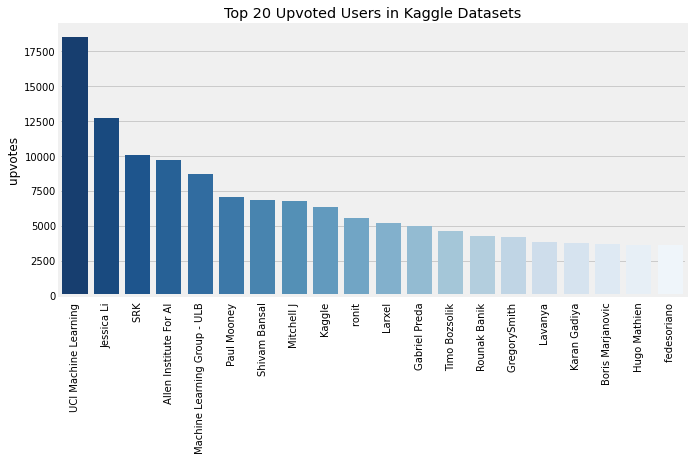

In [18]:
# Creating a new dataframe to visualize which kaggle users take the most upvotes.
upvotes = data.groupby("uploaded_by")["upvotes"].sum().reset_index().sort_values("upvotes", ascending = False).reset_index().drop("index", axis = 1)

plt.figure(figsize = (10,5))
sns.barplot(x = "uploaded_by",
           y = "upvotes",
           data = upvotes[:20], palette = "Blues_r")
plt.xticks(rotation = 90)
plt.title("Top 20 Upvoted Users in Kaggle Datasets")
plt.xlabel("")
plt.show()

In [19]:
data.head(3)

title  \
0  COVID-19 Open Research Dataset Challenge (CORD...   
1               Animal Crossing New Horizons Catalog   
2                        Credit Card Fraud Detection   

                     uploaded_by  Last_Updated_Days  usability  BIGQUERY  \
0        Allen Institute For AI                  12        8.8         0   
1                    Jessica Li                 210        8.2         0   
2  Machine Learning Group - ULB                1440        8.5         0   

   SQLITE  OTHER  JSON  CSV  number_of_files    size_in_MB  upvotes badge  
0       0      1     1    1           558167  14336.000000     9710  Gold  
1       0      0     0    1               30      0.577148     9652  Gold  
2       0      0     0    1                1     69.000000     8712  Gold

### 2.2.2. Which File Types Have They Uploaded the Most?

In [20]:
# Creating a new frame consisting only the most upvoted kaggle users
new_frame1 = data[data.uploaded_by == upvotes.uploaded_by[0]]
new_frame2 = data[data.uploaded_by == upvotes.uploaded_by[1]]
new_frame3 = data[data.uploaded_by == upvotes.uploaded_by[2]]
new_frame4 = data[data.uploaded_by == upvotes.uploaded_by[3]]
new_frame5 = data[data.uploaded_by == upvotes.uploaded_by[4]]

new_frame = pd.concat([new_frame1,new_frame2,new_frame3,new_frame4,new_frame5])
new_frame.head()

title            uploaded_by  \
19                 Pima Indians Diabetes Database  UCI Machine Learning    
20                                   Iris Species  UCI Machine Learning    
24  Breast Cancer Wisconsin (Diagnostic) Data Set  UCI Machine Learning    
34                               Red Wine Quality  UCI Machine Learning    
36                        Mushroom Classification  UCI Machine Learning    

    Last_Updated_Days  usability  BIGQUERY  SQLITE  OTHER  JSON  CSV  \
19               1800        8.8         0       0      0     0    1   
20               1800        7.9         0       1      0     0    1   
24               1800        8.5         0       0      0     0    1   
34               1440        8.8         0       0      0     0    1   
36               1800        8.5         0       0      0     0    1   

    number_of_files  size_in_MB  upvotes badge  
19                1    0.008789     2852  Gold  
20                2    0.003906     2760  Gold  
24                1    0.048828     2511  Gold  
34                1    0.025391     1898  Gold  
36                1    0.034180     1813  Gold

In [21]:
new_frame_for_file_types = new_frame.groupby("uploaded_by")["BIGQUERY","SQLITE","OTHER","JSON","CSV"].sum().reset_index()

fig = px.bar(data_frame = new_frame_for_file_types,
    x = "uploaded_by",
    y = ["BIGQUERY","SQLITE","OTHER","JSON","CSV"])

fig.update_layout(title = "File Distribution of Most Upvoted Kaggle Users")
fig.show()

### 2.2.3 What are Their Average Usability Points?

In [22]:
new_frame_for_usability = new_frame.groupby("uploaded_by")["usability"].mean().reset_index().sort_values("usability", ascending = False).reset_index().drop("index", axis = 1)

fig = px.bar(x = "uploaded_by",
            y = "usability",
            data_frame = new_frame_for_usability,
            color = "usability",
             color_continuous_scale = "Peach")
fig.show()

### 2.2.4.1. Numbers and Ratios of the Badges (Globally)

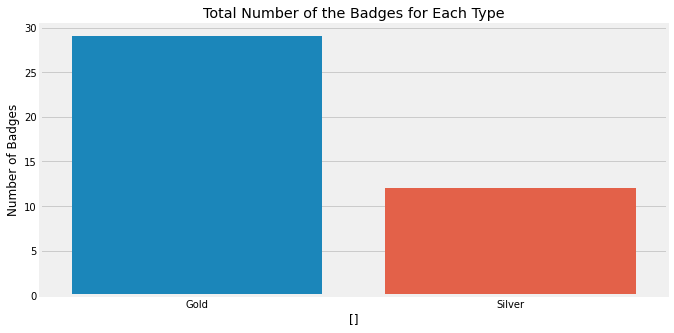

In [23]:
plt.figure(figsize = (10,5))
sns.countplot(new_frame.badge)
plt.xlabel([])
plt.ylabel("Number of Badges")
plt.title("Total Number of the Badges for Each Type")
plt.show()

In [24]:
fig = px.pie(data_frame = new_frame,
    names = "badge",
    color_discrete_sequence = ["#A4160B", "#ffd966"],
             hole = 0.4
             
    )
fig.update_layout(title = "The Ratio of The Badges Belonging to The Most Upvoted Kaggle Users")
fig.show()

### 2.2.4.2. Numbers and Ratios of the Badges (Individually)

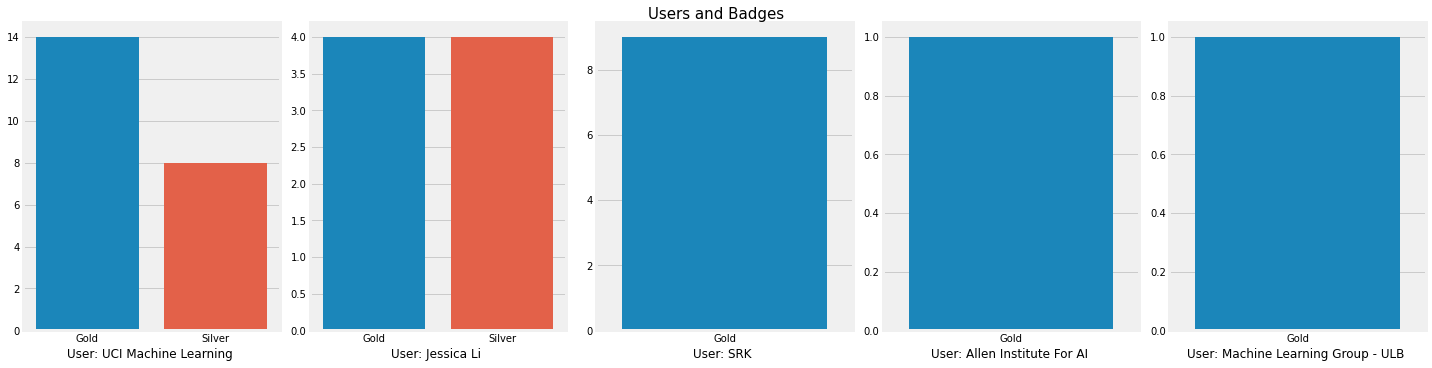

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,5))

ax = ax.flatten()

for ind, axis in enumerate (ax):
    
    ax = sns.countplot(ax = axis ,
                       data = new_frame,
                       x = new_frame[new_frame.uploaded_by == upvotes.uploaded_by[ind]].badge)
                      
                      
    ax.set_xlabel(f"User: {upvotes.uploaded_by[ind]}")
    ax.set_ylabel("")
fig.tight_layout()
plt.suptitle("Users and Badges",va = 'baseline',fontsize = 15)

plt.show()

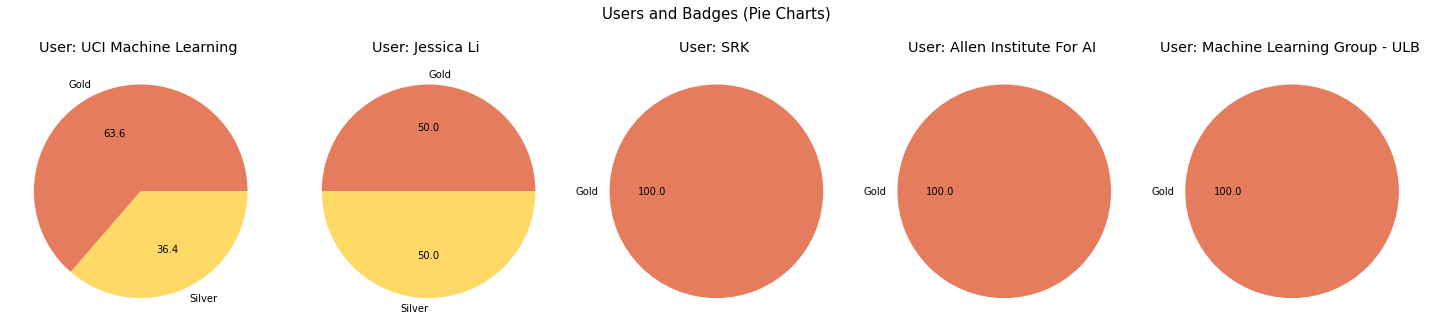

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,5))

ax = ax.flatten()

for ind, axis in enumerate (ax):
    
    axis.pie(x = new_frame[new_frame.uploaded_by == upvotes.uploaded_by[ind]].badge.value_counts(),
                 autopct = "%.1f", 
                 labels = new_frame[new_frame.uploaded_by == upvotes.uploaded_by[ind]].badge.value_counts().index,
             colors = ["#e57c5e", "#ffd966"])
    axis.set_title(f"User: {upvotes.uploaded_by[ind]}")
                                   
                    
    
    
fig.tight_layout()
plt.suptitle("Users and Badges (Pie Charts)",va = 'baseline',fontsize = 15)

plt.show()

<a id='3'></a>
# 3. Designing a Prediction Algorithm

In [27]:
data.head()

title  \
0  COVID-19 Open Research Dataset Challenge (CORD...   
1               Animal Crossing New Horizons Catalog   
2                        Credit Card Fraud Detection   
3                        Netflix Movies and TV Shows   
4                    Novel Corona Virus 2019 Dataset   

                     uploaded_by  Last_Updated_Days  usability  BIGQUERY  \
0        Allen Institute For AI                  12        8.8         0   
1                    Jessica Li                 210        8.2         0   
2  Machine Learning Group - ULB                1440        8.5         0   
3                 Shivam Bansal                  90       10.0         0   
4                           SRK                 180        9.7         0   

   SQLITE  OTHER  JSON  CSV  number_of_files    size_in_MB  upvotes badge  
0       0      1     1    1           558167  14336.000000     9710  Gold  
1       0      0     0    1               30      0.577148     9652  Gold  
2       0      0     0    1                1     69.000000     8712  Gold  
3       0      0     0    1                1      1.000000     6056  Gold  
4       0      0     0    1                6      9.000000     5679  Gold

In [28]:
y = data.pop("badge")
y = pd.get_dummies(y,drop_first = True)

X = data.iloc[:,2:]

In [29]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X.head()

Last_Updated_Days  usability  BIGQUERY    SQLITE     OTHER      JSON  \
0          -1.874157   0.414687 -0.160623 -0.160623  1.441319  4.092676   
1          -1.503625   0.041825 -0.160623 -0.160623 -0.693809 -0.244339   
2           0.798168   0.228256 -0.160623 -0.160623 -0.693809 -0.244339   
3          -1.728190   1.160411 -0.160623 -0.160623 -0.693809 -0.244339   
4          -1.559766   0.973980 -0.160623 -0.160623 -0.693809 -0.244339   

        CSV  number_of_files  size_in_MB    upvotes  
0  0.514423         5.746142    1.610578  11.700865  
1  0.514423        -0.214205   -0.235802  11.627504  
2  0.514423        -0.214515   -0.226989  10.438552  
3  0.514423        -0.214515   -0.235748   7.079130  
4  0.514423        -0.214462   -0.234717   6.602284

In [30]:
model = Sequential([
                    Dense(100, activation = "swish", input_shape = (X.shape[1],)),
                    Dropout(0.5),
                    Dense(50, activation = "swish"),
                    Dropout(0.5),
                    Dense(25,activation = "swish"),
                    Dropout(0.5),
                    Dense(3, activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 7


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [31]:
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = AUC())

history = model.fit(X,y, validation_split = 0.2,
                     callbacks = [EarlyStopping(patience = 30),ReduceLROnPlateau(factor = 0.05, patience = 10, mode = "max")],
                     epochs = 100)

2022-01-07 14:14:02.784314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
25/25 [==============================] - 2s 21ms/step - loss: 1.0168 - auc: 0.6240 - val_loss: 0.6772 - val_auc: 0.7375
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9242 - auc: 0.7616 - val_loss: 0.6389 - val_auc: 0.7037
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.8110 - auc: 0.8181 - val_loss: 0.5944 - val_auc: 0.7079
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.7439 - auc: 0.8243 - val_loss: 0.5666 - val_auc: 0.6908
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6886 - auc: 0.8353 - val_loss: 0.5227 - val_auc: 0.7186
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6492 - auc: 0.8451 - val_loss: 0.5089 - val_auc: 0.7196
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6246 - auc: 0.8554 - val_loss: 0.4914 - val_auc: 0.7311
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6017 - 

Thanks...